<a href="https://colab.research.google.com/github/SahelKherad/3-story-benchmark-transformer/blob/main/1404_08_04_arbitrary_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
import torch.optim as optim

In [46]:
win = 2048
t = np.arange(0, 800000, dtype=np.float32)
a = np.sin(0.05*t)                       # class 0
b = np.linspace(0, 1, 800000, dtype=np.float32)
print(b)
# b = np.arange(0, 80000, 2, dtype=np.float32)

[0.0000000e+00 1.2500016e-06 2.5000031e-06 ... 9.9999750e-01 9.9999875e-01
 1.0000000e+00]


In [47]:
# win = 5
# a = np.arange(1, 50, 2, dtype=np.float32)
# print('a =',a)
# print(len(a))
# b = np.arange(0, 90, 2, dtype=np.float32)   # label 1
# print(len(b))
# print('b =',b)

In [48]:
n_train = 0.7
n_val = 0.15

m_0 = int(n_train * len(a))
l_0 = int(n_val * len(a))

m_1 = int(n_train * len(b))
l_1 = int(n_val * len(b))

X_train_0 = a[0:m_0]
X_val_0   = a[m_0 :m_0+l_0]
X_test_0  = a[m_0+l_0:]

X_train_1 = b[0:m_1]
X_val_1   = b[m_1 :m_1+l_1]
X_test_1  = b[m_1+l_1:]

In [49]:
print(X_train_0)
print('val:\n',X_val_0)
print(X_test_0)

[0.         0.04997917 0.09983342 ... 0.9190692  0.8978803  0.8743766 ]
val:
 [0.84965014 0.821787   0.7929966  ... 0.99938995 0.9998744  0.9980334 ]
[0.993565  0.9865351 0.9769617 ... 0.8884225 0.9105772 0.9289451]


In [50]:
print(X_train_1)
print('val:\n',X_val_1)
print(X_test_1)

[0.0000000e+00 1.2500016e-06 2.5000031e-06 ... 6.9999713e-01 6.9999838e-01
 6.9999963e-01]
val:
 [0.7000009  0.70000213 0.7000034  ... 0.84999734 0.84999853 0.8499998 ]
[0.85000104 0.8500023  0.85000354 ... 0.9999975  0.99999875 1.        ]


In [51]:
con = np.concatenate([X_train_0,X_train_1])
print(con)
mu = con.mean(axis=(0) , keepdims = True)
print(mu)
std = X_train_1.std(axis=(0), keepdims=True) + 1e-6

[0.         0.04997917 0.09983342 ... 0.6999971  0.6999984  0.69999963]
[0.17502682]


In [52]:
X_train_0 = (X_train_0 - mu) / std
X_val_0   = (X_val_0   - mu) / std
X_test_0  = (X_test_0  - mu) / std

X_train_1 = (X_train_1 - mu) / std
X_val_1   = (X_val_1   - mu) / std
X_test_1  = (X_test_1  - mu) / std

In [53]:
def make_windows(data, frame_length, drop_last : bool = True):
    # Calculate how many full frames can be created
    num_frames = len(data) // frame_length
    # print(num_frames)
    # Trim the data to be a perfect multiple of the frame length
    trimmed_data = data[:num_frames * frame_length]

    # Reshape the data into a 2D array of frames
    windows = trimmed_data.reshape((num_frames, frame_length))
    # return trimmed_data.shape , frames.shape
    return windows

In [54]:
# 2) Make windows per class
X_train_0 = make_windows(X_train_0, win, drop_last=True)
X_val_0 = make_windows(X_val_0, win, drop_last=True)
X_test_0 = make_windows(X_test_0, win, drop_last=True)

y_0 = np.zeros((X_train_0.shape[0]+X_val_0.shape[0]+X_test_0.shape[0]), dtype=np.int64)

print('Train_0 = \n')
print(X_train_0.shape)
print(X_val_0.shape)
print(X_test_0.shape)
print(y_0.shape)

X_train_1 = make_windows(X_train_1, win, drop_last=True)
X_val_1 = make_windows(X_val_1, win, drop_last=True)
X_test_1 = make_windows(X_test_1, win, drop_last=True)

y_1 = np.ones((X_train_1.shape[0]+X_val_1.shape[0]+X_test_1.shape[0]), dtype=np.int64)

print('\n Train_1 = \n')
print(X_train_1.shape)
print(X_val_1.shape)
print(X_test_1.shape)
print(y_1.shape)



Train_0 = 

(273, 2048)
(58, 2048)
(58, 2048)
(389,)

 Train_1 = 

(273, 2048)
(58, 2048)
(58, 2048)
(389,)


In [55]:
X_train = np.vstack([X_train_0, X_train_1])[:, :, None]  # [N, 5, 1]
print(X_train.shape)

y_train = np.concatenate([y_0[0:int(len(X_train_0))], y_1[0:int(len(X_train_1))]])             # [N]
print(y_train)
print(y_train.shape)

(546, 2048, 1)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1

In [56]:
from math import perm
perm = np.random.permutation(len(X_train))
X_train = X_train[perm]
y_train = y_train[perm]
print(y_train)

[1 1 0 0 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1
 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1
 0 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 1 0
 0 0 0 1 1 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 0 0 0 0 1 0 1 0 1 1 0 0
 0 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 1 0
 0 1 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0 0 1 1 1 1 1 0 0 1 0 0 1 0 1
 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0 0
 0 1 1 1 0 0 0 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1
 1 0 1 1 0 1 0 0 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0
 1 0 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1 0 1 1 0 0 0 1 0 1 0 0
 1 1 1 0 1 1 0 0 0 1 0 0 1 0 0 1 1 0 1 1 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0
 1 0 1 0 0 0 1 1 1 1 1 0 1 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0 1 0 0 0 1 1 0 0 1
 0 0 1 1 0 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1
 1 1 1 0 0 0 1 0 1 0 0 1 

In [57]:
X_val = np.vstack([X_val_0, X_val_1])[:, :, None]  # [N, 5, 1]
print(X_val.shape)

y_val = np.concatenate([y_0[int(len(X_train_0)):int(len(X_train_0) + len(X_val_0))], y_1[int(len(X_train_1)):int(len(X_train_1) + len(X_val_1))]])             # [N]
print(y_val)
print(y_val.shape)

(116, 2048, 1)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1]
(116,)


In [58]:
X_test =  np.vstack([X_test_0, X_test_1])[:, :, None]  # [N, 5, 1]
print(X_test.shape)

y_test = np.concatenate([y_0[int(len(X_train_0) + len(X_val_0)):], y_1[int(len(X_train_1) + len(X_val_1)):]], axis=0)             # [N]
print(y_test)
print(y_test.shape) # Corrected to print y_val shape

(116, 2048, 1)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1]
(116,)


In [59]:
# 5) Torch tensors
X_train = torch.from_numpy(X_train).float()  # float32
y_train = torch.from_numpy(y_train).long()  # int64
X_val   = torch.from_numpy(X_val).float()
y_val   = torch.from_numpy(y_val).long()
X_test  = torch.from_numpy(X_test).float()
y_test  = torch.from_numpy(y_test).long()

In [60]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

torch.Size([546, 2048, 1]) torch.Size([546])
torch.Size([116, 2048, 1]) torch.Size([116])
torch.Size([116, 2048, 1]) torch.Size([116])


In [61]:
class SeqDataset(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor):
        self.X = X  # [N, seq_len, 1]
        self.y = y  # [N]
    def __len__(self): return self.y.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i]

train_ds = SeqDataset(X_train, y_train)
# print(X_train.shape)
# print(train_ds[0])
# print(train_ds[1])
# print(train_ds[2])
val_ds   = SeqDataset(X_val,   y_val)
test_ds  = SeqDataset(X_test,  y_test)

In [62]:
# 6) DataLoaders: shuffle only the training set
batch_size = 512
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

# tiny = 200
# train_loader = DataLoader(SeqDataset(X_train[:tiny], y_train[:tiny]),batch_size=50, shuffle=True)

# print('ppp',next(iter(train_loader)))

In [63]:
# 7) Example: adapt a batch for a Transformer [seq_len, batch, d_model]
xb, yb = next(iter(train_loader))   # xb: [B, 5, 1]
# xb_t = xb.transpose(0, 1)           # -> [5, B, 1]
# print("Shapes:", xb.shape, xb_t.shape, yb.shape)

In [64]:
class LearnablePositionalEncoding(nn.Module):
    """
    Learnable positional encoding added to token embeddings.
    Shape stored: [1, max_len, d_model]
    """
    def __init__(self, d_model: int, max_len: int):
        super().__init__()
        self.pe = nn.Parameter(torch.zeros(1, max_len, d_model))
        print(self.pe)
        nn.init.trunc_normal_(self.pe, std=0.02)

    def forward(self, x):
        # x: [B, T, d_model]
        T = x.size(1)
        return x + self.pe[:, :T, :]

In [65]:
 pe = LearnablePositionalEncoding(d_model=3, max_len=5)
#  print(pe(batch_X[0]))

Parameter containing:
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], requires_grad=True)


In [66]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, d_model=64, nhead=2, num_layers=2, d_ff=256, seq_len=5, num_classes=2, dropout=0.1):
        super().__init__()
        self.inp = nn.Linear(1, d_model)                            # project feature_dim=1 -> d_model
        self.pos = LearnablePositionalEncoding(d_model, seq_len)    # learnable PE
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=d_ff, dropout=dropout,
            batch_first=True                                        # so we keep [B, T, d]
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # x: [B, T, 1]
        x = self.inp(x)                  # [B, T, d]
        x = self.pos(x)                  # add learnable PE
        x = self.encoder(x)              # [B, T, d]
        x = self.norm(x)
        x = x.mean(dim=1)                # mean pool over time
        logits = self.head(x)            # [B, C]
        return logits

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seq_len = X_train.shape[1]
num_classes = 2
model = TimeSeriesTransformer(d_model=64, nhead=2, num_layers=2, d_ff=256,seq_len=seq_len, num_classes=num_classes).to(device)

Parameter containing:
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], requires_grad=True)


In [68]:
# Optional class weights for CE or focal alpha; compute from training labels
class_counts = torch.bincount(y_train)
class_weights = (class_counts.sum() / (class_counts.float().clamp(min=1)))  # inverse freq
class_weights = class_weights / class_weights.sum() * num_classes           # normalize
class_weights = class_weights.to(device)

In [69]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
# loss = nn.BCELoss() # BCELoss = no sigmoid built-in
# loss = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

In [70]:
num_epochs = 50
tr_losses = []
tr_accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
     model.train()
     total_loss = 0
     total_samples = 0
     correct_predictions = 0
     for xb, yb in train_loader:
        xb , yb = xb.to(device) , yb.to(device).long()
        optimizer.zero_grad()
        output = model(xb)
        # print('output',output)
        # print('max',torch.max(output, 1))
        # print('yb',yb)

        loss = loss_fn(output , yb)
        # print('loss',loss)
        # optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        # print(loss.item())
        # print(xb.size(0))
        # print('total:',total_loss)

        # Calculate accuracy
        pred = output.argmax(dim=1) # the index of the maximum value for each column
        # print('p',predicted)
        # print('real',yb)
        total_samples += xb.size(0)
        # print(total_samples)
        correct_predictions += (pred == yb).sum().item()
        # print(correct_predictions)

     epoch_loss = total_loss / total_samples
     epoch_accuracy = correct_predictions / total_samples
     tr_losses.append(epoch_loss)
     tr_accs.append(epoch_accuracy)

    #  print(f"Epoch {epoch+1}/{num_epochs}: " f"Train Loss: {epoch_loss:.4f}, "f"Train Accuracy: {epoch_accuracy:.4f}")

     model.eval()
     val_correct_predictions = 0
     val_total_samples = 0
     val_total_loss = 0
     with torch.no_grad():
          for xb, yb in val_loader:
              xb, yb = xb.to(device), yb.to(device).long()
              output = model(xb)
              val_loss = loss_fn(output,yb)
              val_total_loss += val_loss.item() * xb.size(0)
              pred = output.argmax(dim=1)
              val_total_samples += xb.size(0)
              val_correct_predictions += (pred == yb).sum().item()

     val_epoch_loss = val_total_loss / val_total_samples
     val_epoch_accuracy = val_correct_predictions / val_total_samples
    #  print(    f"Validation Loss: {val_epoch_loss:.4f}, "f"Validation Accuracy: {val_epoch_accuracy:.4f}\n")
     val_losses.append(val_epoch_loss)
     val_accs.append(val_epoch_accuracy)
     print(f"Epoch {epoch+1}/{num_epochs}: " f"Train Loss: {epoch_loss:.4f}, "f"Train Accuracy: {epoch_accuracy:.4f} | "f"Validation Loss: {val_epoch_loss:.4f}, "f"Validation Accuracy: {val_epoch_accuracy:.4f}\n")





Epoch 1/50: Train Loss: 0.5743, Train Accuracy: 0.4890 | Validation Loss: 0.2292, Validation Accuracy: 1.0000

Epoch 2/50: Train Loss: 0.3182, Train Accuracy: 0.9249 | Validation Loss: 0.0956, Validation Accuracy: 1.0000

Epoch 3/50: Train Loss: 0.1799, Train Accuracy: 0.9396 | Validation Loss: 0.0461, Validation Accuracy: 1.0000

Epoch 4/50: Train Loss: 0.1006, Train Accuracy: 0.9652 | Validation Loss: 0.0272, Validation Accuracy: 1.0000

Epoch 5/50: Train Loss: 0.0532, Train Accuracy: 0.9945 | Validation Loss: 0.0181, Validation Accuracy: 1.0000

Epoch 6/50: Train Loss: 0.0284, Train Accuracy: 1.0000 | Validation Loss: 0.0128, Validation Accuracy: 1.0000

Epoch 7/50: Train Loss: 0.0167, Train Accuracy: 1.0000 | Validation Loss: 0.0093, Validation Accuracy: 1.0000

Epoch 8/50: Train Loss: 0.0111, Train Accuracy: 1.0000 | Validation Loss: 0.0070, Validation Accuracy: 1.0000

Epoch 9/50: Train Loss: 0.0081, Train Accuracy: 1.0000 | Validation Loss: 0.0055, Validation Accuracy: 1.0000

E

In [71]:
import torch.nn.functional as F
val_probs = []
val_true  = []
with torch.no_grad():
    for xb, yb in val_loader:
        out = model(xb.to(device))
        val_probs.append(F.softmax(out, dim=1).max(1).values.cpu())
        val_true.append(yb)
val_probs = torch.cat(val_probs)
print('Val avg max-softmax:', val_probs.mean().item())


Val avg max-softmax: 0.9992543458938599


In [72]:
# =========================
# Test evaluation (add this)
# =========================
model.eval()
test_correct = 0
test_total = 0
test_loss_total = 0.0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device).long()
        out = model(xb)
        loss = loss_fn(out, yb)
        test_loss_total += loss.item() * xb.size(0)
        pred = out.argmax(dim=1)
        test_correct += (pred == yb).sum().item()
        test_total += xb.size(0)

print(f"Test Loss: {test_loss_total/test_total:.4f}, Test Acc: {test_correct/test_total:.4f}")


Test Loss: 0.0008, Test Acc: 1.0000


In [73]:
from sklearn.metrics import confusion_matrix
import numpy as np
all_pred, all_true = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        out = model(xb.to(device))
        all_pred.append(out.argmax(1).cpu().numpy())
        all_true.append(yb.numpy())
cm = confusion_matrix(np.concatenate(all_true), np.concatenate(all_pred))
print(cm)


[[58  0]
 [ 0 58]]


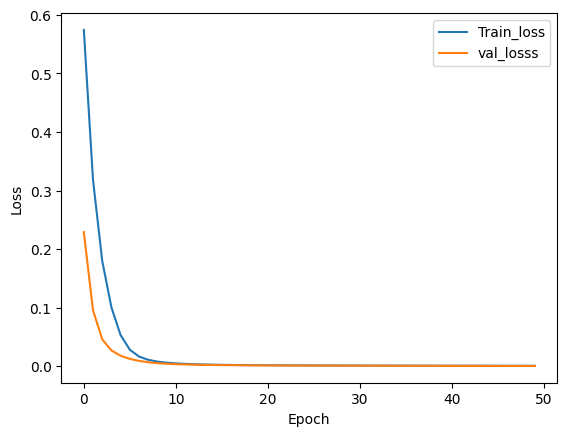

In [74]:
epoch = np.arange(0,num_epochs , 1)
import matplotlib.pyplot as plt

plt.plot(epoch, tr_losses , label="Train_loss")
plt.plot(epoch, val_losses, label="val_losss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

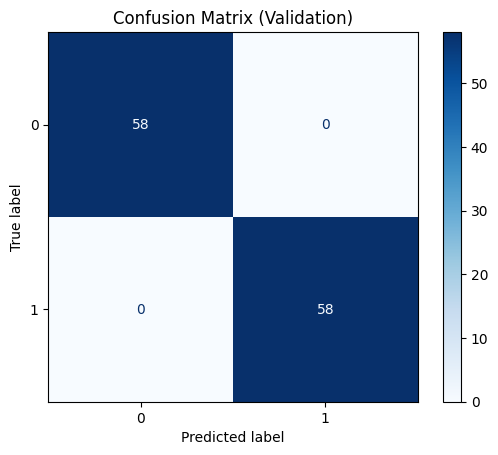

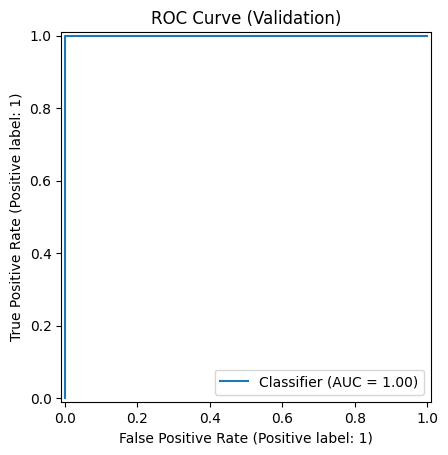

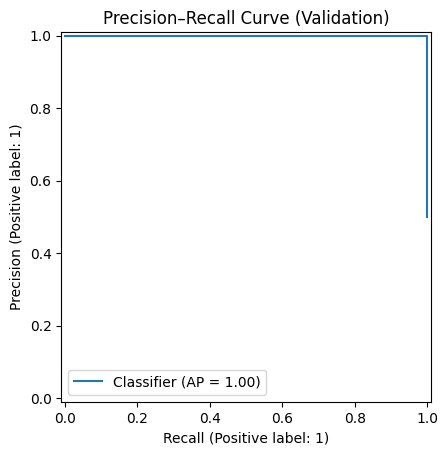

In [75]:
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

y_true, y_pred, y_score = [], [], []
model.eval()

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device).long()   # targets should be int for CE
        logits = model(xb)                             # [B,2]

        # 1) Probability of class 1
        probs  = torch.softmax(logits, dim=1)          # [B,2]
        score1 = probs[:, 1]                           # [B]

        # 2) Predicted class index
        preds  = logits.argmax(dim=1)                  # [B]

        # Save results
        y_true.extend(yb.cpu().tolist())
        y_pred.extend(preds.cpu().tolist())
        y_score.extend(score1.cpu().tolist())

# 1) Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Validation)")
plt.show()

# 2) ROC
RocCurveDisplay.from_predictions(y_true, y_score)
plt.title("ROC Curve (Validation)")
plt.show()

# 3) Precision–Recall
PrecisionRecallDisplay.from_predictions(y_true, y_score)
plt.title("Precision–Recall Curve (Validation)")
plt.show()

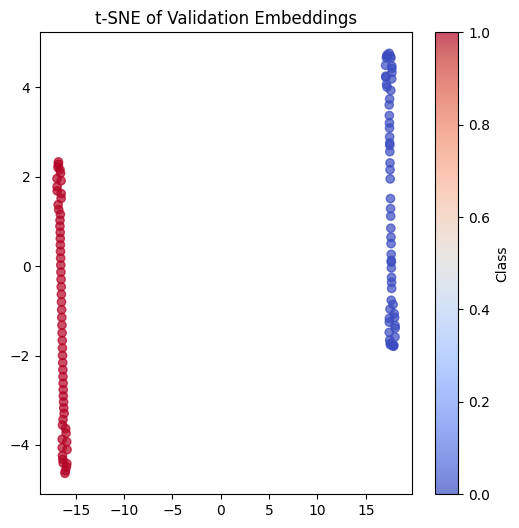

In [76]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

model.eval()
all_embeds, all_labels = [], []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        # Pass through encoder only (skip classifier head)
        embeds = model.encoder(model.inp(xb) + model.pos(model.inp(xb)))
        embeds = embeds.mean(dim=1)                # [B, d_model]

        all_embeds.append(embeds.cpu())
        all_labels.append(yb.cpu())

# Concatenate all batches
all_embeds = torch.cat(all_embeds, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

# Run t-SNE
X_2d = TSNE(n_components=2, random_state=42).fit_transform(all_embeds)

# Plot
plt.figure(figsize=(6,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=all_labels, cmap="coolwarm", alpha=0.7)
plt.colorbar(label="Class")
plt.title("t-SNE of Validation Embeddings")
plt.show()
